File modified by Julia Ive julia.ive84@gmail.com

https://github.com/rampopat/humour-reg

Original work Copyright (c) 2021 Ram Popat

In [ ]:
# Imports

import re
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from torch.utils.data import Dataset, random_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from collections import Counter, defaultdict
from scipy.sparse import hstack
import seaborn as sns
import matplotlib.pyplot as plt
import codecs
import string
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.stem.porter import PorterStemmer
from scipy import stats

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


## Loading Data

In [ ]:
PATH_TO_DATA = 'humour-reg/'

In [ ]:
# Load data
train_df = pd.read_csv(PATH_TO_DATA + 'train.csv')
val_df = pd.read_csv(PATH_TO_DATA + 'dev.csv')
test_df = pd.read_csv(PATH_TO_DATA + 'test.csv')
all_df = pd.concat([train_df, val_df, test_df], ignore_index=True)

##Dataset Analysis

In [ ]:
meanGrade = all_df['meanGrade']
print(meanGrade.describe())
meanGrade.var()

count    15095.000000
mean         0.936246
std          0.581024
min          0.000000
25%          0.400000
50%          0.800000
75%          1.400000
max          3.000000
Name: meanGrade, dtype: float64


0.33758916316094095

In [ ]:
all_df[(meanGrade==0)]
all_df[(meanGrade==3)]

,id,original,edit,grades,meanGrade
1490,3404,President Trump 's first year <anniversary/> r...,Kindergarten,33333,3.0
6075,1229,Recent Scandals Highlight Trump 's Chaotic <Ma...,Fashion,33333,3.0
11063,11404,Hillary Clinton Supporters Filed a Complaint A...,themselves,33333,3.0
11595,1805,RAF fighters intercept two Russian <bombers/> ...,drunks,33333,3.0
12067,14764,Trump Mocks Schumer ’s Tears ; Vows to ‘ Make ...,Insane,33333,3.0


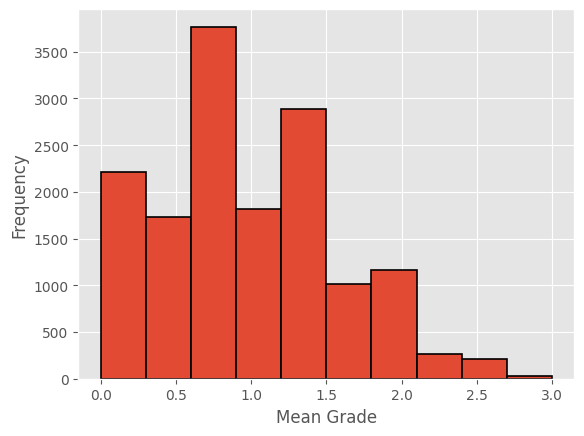

In [ ]:
plt.style.use('ggplot')
hist, bin_edges = np.histogram(meanGrade)

fig, ax = plt.subplots()
ax.hist(meanGrade, bin_edges, cumulative=False, edgecolor='black', linewidth=1.2)
ax.set_xlabel('Mean Grade')
ax.set_ylabel('Frequency')
plt.show()

In [ ]:
print('Dataset sizes')
print(len(train_df), len(val_df), len(test_df), len(all_df))

Dataset sizes
9652 2419 3024 15095


# Model Performance (MSE and RMSE)

In [ ]:
# How we print the model performance
def model_performance(output, target, print_output=False):
    """
    Returns SSE and MSE per batch (printing the MSE and the RMSE)
    """
    # Individually find which headline has the highest and lowest scores
    ex_sq_error = list()
    for pred, trg_ex in zip(output, target):
      sq_error_ex = (output - target)**2
      ex_sq_error.append(sq_error_ex)

    indices = np.argsort(np.array(ex_sq_error))
    best_examples  = indices[:5]
    worst_examples  = indices[-5:]
    print(best_examples)
    print(worst_examples)

    sq_error = (output - target)**2

    sse = np.sum(sq_error)
    mse = np.mean(sq_error)
    rmse = np.sqrt(mse)

    if print_output:
        print(f'| MSE: {mse:.4f} | RMSE: {rmse:.4f} |')

    return sse, mse

In [ ]:
def get_vocab(df):
  vocab = set()
  for headline in pd.concat([df['original'], df['edit']]):
    vocab.update(headline.split())
  return vocab

train_vocab = get_vocab(train_df)
val_vocab = get_vocab(val_df)
test_vocab = get_vocab(test_df)

print("Number of unique words in training set: %d" % len(train_vocab))
print("Number of unique words in validation set: %d" % len(val_vocab))
print("Number of unique words in test set: %d" % len(test_vocab))
print("Number of words occurring in validation set not seen in training set: %d" % len(val_vocab.difference(train_vocab)))
print("Number of words occurring in test set not seen in training set: %d" % len(test_vocab.difference(train_vocab)))

Number of unique words in training set: 16801
Number of unique words in validation set: 6665
Number of unique words in test set: 7860
Number of words occurring in validation set not seen in training set: 2466
Number of words occurring in test set not seen in training set: 2986


# Traditional ML Approach

### CountVectorize and TF-IDF with Regression Models (LR, SVR, Random Forest)

In [ ]:
# Create columns for full headline before & after edit
# For training set
train_df["new"] = train_df.apply(
  lambda row: re.sub(r"<.+/>", row["edit"], row["original"]), axis=1
)
train_df["old"] = train_df["original"].str.replace(r"<(.+)/>", "\g<1>")

# For test set
test_df["new"] = test_df.apply(
  lambda row: re.sub(r"<.+/>", row["edit"], row["original"]), axis=1
)
test_df["old"] = test_df["original"].str.replace(r"<(.+)/>", "\g<1>")

# We train a Tf-idf model for original and new headline
count_vect = CountVectorizer(stop_words='english')
train_counts = count_vect.fit_transform(train_df['old'])
transformer = TfidfTransformer().fit(train_counts)
train_counts = transformer.transform(train_counts)

# For getting the idf weightings
df_idf = pd.DataFrame(transformer.idf_, index=count_vect.get_feature_names_out(),columns=["idf_weights"])
df_idf.sort_values(by=['idf_weights'])
print(df_idf)


count_vect_edited = CountVectorizer(stop_words='english')
train_counts_edited = count_vect_edited.fit_transform(train_df['new'])
transformer_edited = TfidfTransformer().fit(train_counts_edited)
train_counts_edited = transformer_edited.transform(train_counts_edited)

training_x = hstack((train_counts, train_counts_edited))
training_y = train_df['meanGrade']

# Processing test data
# Note that you re-use the vectorisers learnt on the train data
test_counts = count_vect.transform(test_df['old'])
test_counts = transformer.transform(test_counts)
test_counts_edited = count_vect_edited.transform(test_df['new'])
test_counts_edited = transformer_edited.transform(test_counts_edited)

testing_x = hstack((test_counts, test_counts_edited))
testing_y = test_df['meanGrade']

<ipython-input-6-eab281c8814a>:6: FutureWarning: The default value of regex will change from True to False in a future version.
  train_df["old"] = train_df["original"].str.replace(r"<(.+)/>", "\g<1>")
<ipython-input-6-eab281c8814a>:12: FutureWarning: The default value of regex will change from True to False in a future version.
  test_df["old"] = test_df["original"].str.replace(r"<(.+)/>", "\g<1>")


            idf_weights
000            5.940918
02             8.788730
10             5.940918
100            6.879187
100k           8.788730
...                 ...
zones          8.229114
zte            8.788730
zuck           8.788730
zucker         8.788730
zuckerberg     7.977799

[7001 rows x 1 columns]


In [ ]:
df_idf.sort_values(['idf_weights'], ascending=False)

,idf_weights
waiter,9.481877
accounting,9.481877
trick,9.481877
disavow,9.481877
smashes,9.481877
...,...
donald,4.176087
russia,4.085979
house,3.879758
says,3.719825


# Baseline from Mean

Predicts mean of training set regardless of input

In [ ]:
# Baseline for the task
# Assign all elements in a tensor of zeros with the same length as testing_y to the mean of training_y
# This represents the baseline predictions (mean of target values in training set)
pred_baseline = torch.zeros(len(testing_y)) + np.mean(training_y)
print("\nBaseline performance:")
sse, mse = model_performance(pred_baseline, testing_y, True)


Baseline performance:
[[2366 2018  259 ...  852  935 1712]
 [2366 2018  259 ...  852  935 1712]
 [2366 2018  259 ...  852  935 1712]
 [2366 2018  259 ...  852  935 1712]
 [2366 2018  259 ...  852  935 1712]]
[[2366 2018  259 ...  852  935 1712]
 [2366 2018  259 ...  852  935 1712]
 [2366 2018  259 ...  852  935 1712]
 [2366 2018  259 ...  852  935 1712]
 [2366 2018  259 ...  852  935 1712]]
| MSE: 0.3303 | RMSE: 0.5747 |


### Linear Regression:

In [ ]:
# Training model
lr = LinearRegression().fit(training_x, training_y)

# Getting training set predictions
predicted_train = lr.predict(training_x)

# Test predictions
predicted = lr.predict(testing_x)

# We run the evaluation:
print("\nTrain performance:")
sse, mse = model_performance(predicted_train, training_y, True)

print("\nTest performance:")
sse, mse = model_performance(predicted, testing_y, True)


Support Vector Regression:

In [ ]:
training_x

<9652x17165 sparse matrix of type '<class 'numpy.float64'>'
	with 147721 stored elements in Compressed Sparse Row format>

In [ ]:
# Training model
svr = SVR().fit(training_x, training_y)

# Getting training set predictions
predicted_train = svr.predict(training_x)

# Test predictions
predicted = svr.predict(testing_x)

# We run the evaluation:
print("\nTrain performance:")
sse, mse = model_performance(predicted_train, training_y, True)

print("\nDev performance:")
sse, mse = model_performance(predicted, testing_y, True)

Random Forest Regressor:

In [ ]:
# Training model
rfr = RandomForestRegressor()
rfr = rfr.fit(training_x, training_y)

# Getting training set predictions
predicted_train = rfr.predict(training_x)

# Test predictions
predicted = rfr.predict(testing_x)

# We run the evaluation:
print("\nTrain performance:")
sse, mse = model_performance(predicted_train, training_y, True)

print("\nDev performance:")
sse, mse = model_performance(predicted, testing_y, True)

from sklearn.metrics import r2_score
print(r2_score(testing_y, predicted))


Train performance:
[[ 834 4585 2073 ... 7852 2043 1490]
 [ 834 4585 2073 ... 7852 2043 1490]
 [ 834 4585 2073 ... 7852 2043 1490]
 [ 834 4585 2073 ... 7852 2043 1490]
 [ 834 4585 2073 ... 7852 2043 1490]]
[[ 834 4585 2073 ... 7852 2043 1490]
 [ 834 4585 2073 ... 7852 2043 1490]
 [ 834 4585 2073 ... 7852 2043 1490]
 [ 834 4585 2073 ... 7852 2043 1490]
 [ 834 4585 2073 ... 7852 2043 1490]]
| MSE: 0.0484 | RMSE: 0.2199 |

Dev performance:
[[1484 1310   95 ... 1712 2687 1054]
 [1484 1310   95 ... 1712 2687 1054]
 [1484 1310   95 ... 1712 2687 1054]
 [1484 1310   95 ... 1712 2687 1054]
 [1484 1310   95 ... 1712 2687 1054]]
[[1484 1310   95 ... 1712 2687 1054]
 [1484 1310   95 ... 1712 2687 1054]
 [1484 1310   95 ... 1712 2687 1054]
 [1484 1310   95 ... 1712 2687 1054]
 [1484 1310   95 ... 1712 2687 1054]]
| MSE: 0.3346 | RMSE: 0.5784 |
-0.013038756233338056


# Data Preprocessing Functions

In this section we have implemented some basic functions for preprocessing our data including punctuation removal, whitespace removal, stop word removal, lowercasing, number removal, and word lemmatizing.

In [ ]:
lemmatizer = WordNetLemmatizer()
wordnet_map = {"N":wordnet.NOUN, "V":wordnet.VERB, "J":wordnet.ADJ, "R":wordnet.ADV}

def remove_punct(headline):
  table = str.maketrans('', '', "!\"#$%&'()*+,-.:;=?@[\]^_`{|}~»‘’“”—")
  return headline.translate(table)


def remove_excessive_whitespace(headline):
  return re.sub(' +', ' ', headline).strip()


def to_lower(headline):
  return headline.lower()


def remove_stop_words(headline):
  stop_words = set(["the", "a", "an", "that", "is", "and", "or", "its", "in", "m", "s", "t", "ll"])

  headline_SWR = []
  for token in headline.split(" "):
    if token not in stop_words and token != "":
        headline_SWR.append(token)

  return " ".join(headline_SWR)


def remove_numbers(headline):
  return re.sub(r'\d+', '', headline)


def lemmatize_words(headline):
  pos_tagged_text = nltk.pos_tag(headline.split())
  return " ".join([lemmatizer.lemmatize(word, wordnet_map.get(pos[0], wordnet.NOUN)) for word, pos in pos_tagged_text])

def characterize(headline):
  x = headline.split()
  first = x[0]
  character = ([*first])
  return ' '.join(character)

In [ ]:
# Wrapper Function to process all the functions above
def preprocess_fn(headline, punct_removal=True, whitespace_removal=True, stopword_removal=True, number_removal=True, word_lemmatize=True, chracaterize=True):
  headline = headline.lower()

  if punct_removal:
    headline = remove_punct(headline)

  if whitespace_removal:
    headline = remove_excessive_whitespace(headline)

  if stopword_removal:
    headline = remove_stop_words(headline)

  if number_removal:
    headline = remove_numbers(headline)

  if word_lemmatize:
    headline = lemmatize_words(headline)

  if chracaterize:
    headline = characterize(headline)

  return headline

def preprocess(df, punct_removal=True, whitespace_removal=True, stopword_removal=True, number_removal=True, word_lemmatize=True):
  '''
    Creates new columns 'original_preprocessed' and 'edit_preprocessed' in dataframe
    containing preprocessed version of 'original' and 'edit' columns.
  '''
  df['original_preprocessed'] = df['original'].apply(preprocess_fn, args=(punct_removal, whitespace_removal, stopword_removal, number_removal, word_lemmatize, False))
  df['edit_preprocessed'] = df['edit'].apply(preprocess_fn, args=(punct_removal, whitespace_removal, stopword_removal, number_removal, word_lemmatize, False))

In [ ]:
preprocess(train_df)
preprocess(test_df)

In [ ]:
# We train a Tf-idf model for original and new headline
count_vect = CountVectorizer(stop_words='english')
# note that we take the column with pre-processed data
train_counts = count_vect.fit_transform(train_df['original_preprocessed'])
transformer = TfidfTransformer().fit(train_counts)
train_counts = transformer.transform(train_counts)

count_vect_edited = CountVectorizer(stop_words='english')
train_counts_edited = count_vect_edited.fit_transform(train_df['edit_preprocessed'])
transformer_edited = TfidfTransformer().fit(train_counts_edited)
train_counts_edited = transformer_edited.transform(train_counts_edited)

# Character tokenization done by CountVectorizer
char_count_vect = CountVectorizer(analyzer='char')
train_char_counts = char_count_vect.fit_transform(train_df['original_preprocessed'])

char_count_vect_edited = CountVectorizer(analyzer='char')
train_char_counts_edited = char_count_vect_edited.fit_transform(train_df['edit_preprocessed'])

# Stack all 4 arrays
training_x = hstack((train_counts, train_counts_edited, train_char_counts, train_char_counts_edited))
training_y = train_df['meanGrade']

# Processing test data
test_counts = count_vect.transform(test_df['original_preprocessed'])
test_counts = transformer.transform(test_counts)
test_counts_edited = count_vect_edited.transform(test_df['edit_preprocessed'])
test_counts_edited = transformer_edited.transform(test_counts_edited)

test_char_counts = char_count_vect.transform(test_df['original_preprocessed'])
test_char_counts_edited = char_count_vect_edited.transform(test_df['edit_preprocessed'])


testing_x = hstack((test_counts, test_counts_edited, test_char_counts, test_char_counts_edited))
testing_y = test_df['meanGrade']

## Models with Preprocessed Data

In [ ]:
# Linear Regression Training model
lr = LinearRegression().fit(training_x, training_y)

# Getting training set predictions
predicted_train = lr.predict(training_x)

# Test predictions
predicted = lr.predict(testing_x)

print("\nTest performance:")
sse, mse = model_performance(predicted, testing_y, True)

In [ ]:
# Support Vector Regression Training model
svr = SVR().fit(training_x, training_y)

# Getting training set predictions
predicted_train = svr.predict(training_x)

# Test predictions
predicted = svr.predict(testing_x)

print("\nTest performance:")
sse, mse = model_performance(predicted, testing_y, True)

In [ ]:
# Random Forest Regression Training model
rfr = RandomForestRegressor().fit(training_x, training_y)

# Getting training set predictions
predicted_train = rfr.predict(training_x)

# Test predictions
predicted = rfr.predict(testing_x)

print("\nTest performance:")
sse, mse = model_performance(predicted, testing_y, True)

**SVR Grid Search**
Hyper-parameter tuning

In [ ]:
from datetime import datetime

# Define Grid
grid = {
    'kernel': ["rbf", "linear", "poly"],
    'C': [1, 2, 10],
    'gamma': [0.0001, 0.001, 0.01, 2],
    'epsilon': [0.1, 0.2, 2]
}
# Save start time
start = datetime.now()

# Grid Search function
CV_svr = GridSearchCV(estimator=SVR(), param_grid=grid, cv= 3, n_jobs= -1, verbose = 2, scoring = 'neg_mean_squared_error')
CV_svr.fit(training_x, training_y)

# Save end time
end = datetime.now()
diff = end - start

# Calculate time taken
print("time taken: ", diff.total_seconds()/60 )

print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n",CV_svr.best_estimator_)
print("\n The best score across ALL searched params:\n",CV_svr.best_score_)
print("\n The best parameters across ALL searched params:\n",CV_svr.best_params_)

In [ ]:
# Support Vector Regression Training model with optimals Hyperparameters
svr = SVR(kernel="rbf", C=10, epsilon=0.2, gamma=0.001).fit(training_x, training_y)

# Getting training set predictions
predicted_train = svr.predict(training_x)

# Test predictions
predicted = svr.predict(testing_x)

# We run the evaluation:
print("\nTrain performance:")
sse, mse = model_performance(predicted_train, training_y, True)

print("\nTest performance:")
sse, mse = model_performance(predicted, testing_y, True)

**RFR Grid Search**
Hyper-parameter tuning

In [ ]:
from datetime import datetime

# Define Grid
grid = {
    'criterion': ["squared_error"],
    'n_estimators': [150, 200, 250],
    'max_depth' : [100, 200,300],
    'min_samples_leaf': [5,10, 15]
}

start = datetime.now()

## Grid Search function
CV_rfr = GridSearchCV(estimator=RandomForestRegressor(), param_grid=grid, cv= 3, n_jobs= -1, verbose = 2, scoring = "neg_mean_squared_error")
CV_rfr.fit(training_x, training_y)

end = datetime.now()
diff = end - start
print("time taken: ", diff.total_seconds()/60 )

print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n",CV_rfr.best_estimator_)
print("\n The best score across ALL searched params:\n",CV_rfr.best_score_)
print("\n The best parameters across ALL searched params:\n",CV_rfr.best_params_)

In [ ]:
# Random Forest Regression Training model with optimal Hyperparameters
rfr = RandomForestRegressor(criterion="squared_error", max_depth=300, min_samples_leaf=5, n_estimators=250)
rfr = rfr.fit(training_x, training_y)

# Getting training set predictions
predicted_train = rfr.predict(training_x)

# Test predictions
predicted = rfr.predict(testing_x)

# We run the evaluation:
print("\nTrain performance:")
sse, mse = model_performance(predicted_train, training_y, True)

print("\nTest performance:")
sse, mse = model_performance(predicted, testing_y, True)